# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal


#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Inputs e Outputs

In [7]:
FOLDER_OUTPUT = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED_old/"

# Extraindo informações dos arquivos ".mseed"

In [8]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [9]:
len(filenames_MSEED)

124247

In [10]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime]], index=['filename', 'mergulho', 'stream_number','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [11]:
pandas_mseed_lst = []

with Pool(processes=8) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████| 124247/124247 [08:32<00:00, 242.55it/s]


In [78]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [79]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime,format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final


,filename,mergulho,stream_number,starttime,endtime
0,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980
1,pa0002au_002_151112_143818,0002,002,2015-11-12 14:38:18,2015-11-12 14:40:17.930
2,pa0002au_004_151112_144218,0002,004,2015-11-12 14:42:18,2015-11-12 14:44:17.930
3,pa0002au_003_151112_144018,0002,003,2015-11-12 14:40:18,2015-11-12 14:42:17.930
4,pa0002au_006_151112_144618,0002,006,2015-11-12 14:46:18,2015-11-12 14:48:17.930
...,...,...,...,...,...
124242,pa0296au_010_211104_063338,0296,010,2021-11-04 06:33:38,2021-11-04 06:43:37.990
124243,pa0296au_011_211104_064338,0296,011,2021-11-04 06:43:38,2021-11-04 06:53:37.990
124244,pa0295au_006_211104_011556,0295,006,2021-11-04 01:15:56,2021-11-04 01:25:55.990
124245,pa0295au_005_211104_010556,0295,005,2021-11-04 01:05:56,2021-11-04 01:15:55.990


# Extraindo informações dos arquivos ".csv"

In [14]:
filename_csv = '/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

In [15]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [16]:
dataframe_csv['year'] = dataframe_csv['time'].dt.strftime("%Y")
dataframe_csv['month'] = dataframe_csv['time'].dt.strftime("%m")
dataframe_csv['n_month'] = dataframe_csv['time'].dt.strftime("%b")
dataframe_csv['depth'] = dataframe_csv['depth'] * -1

/tmp/ipykernel_807206/1214737771.py:56: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,


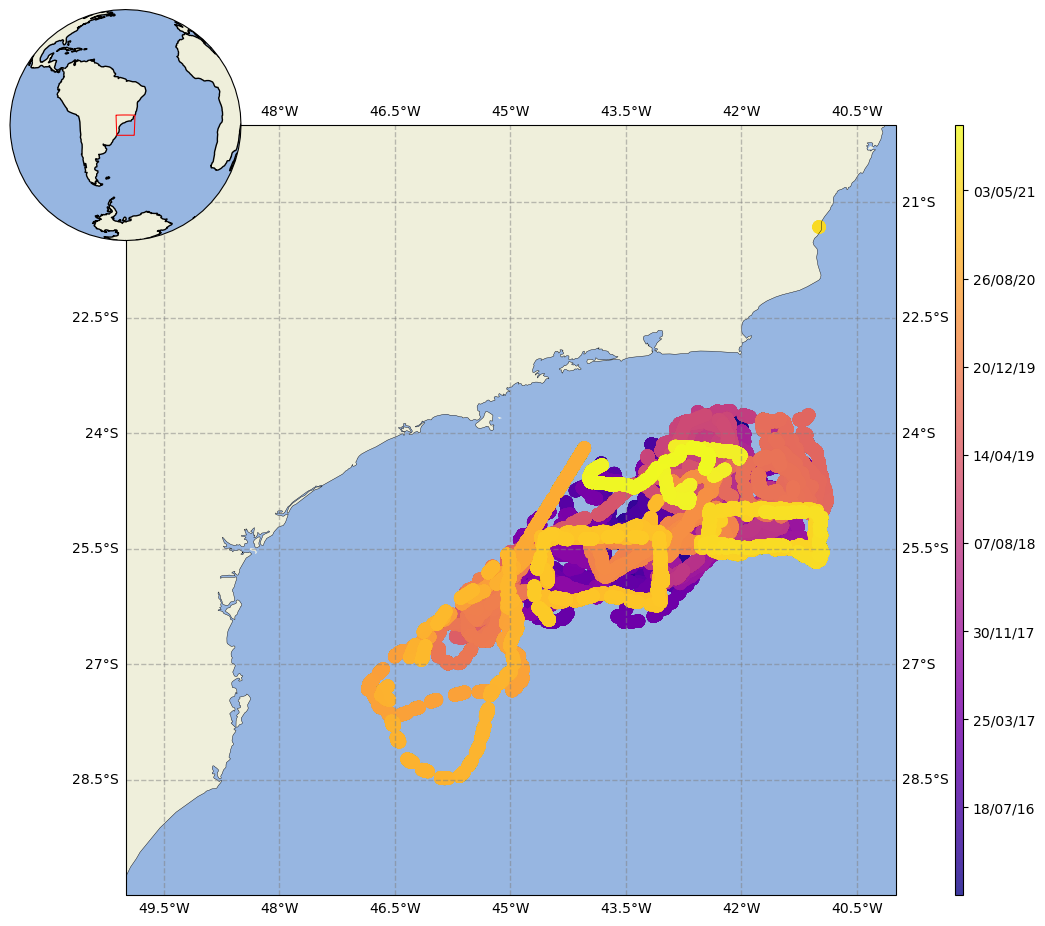

In [17]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Selecionando um evento: 

In [72]:
events = pd.read_csv('/run/media/dIOGOLOC/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/tabela_eventos_bacia_de_santos_mag_2.csv',sep=';',parse_dates=['origin'])
events.sort_values(by='origin')
print("Found %s event(s)" % len(events))

Found 23 event(s)


In [73]:
events

,evid,origin,longitude,latitude,depth,magnitude,magnitudet,region,author,mode
0,usp2021znwb,2021-12-30 08:17:55.761000+00:00,-42.334,-23.869,0,2.8,mR,Saquarema-RJ,jroberto,M
1,usp2021lmlr,2021-06-13 08:25:33+00:00,-44.750,-27.096,0,3.3,mR,South Atlantic Ocean,marcelo,M
2,usp2020fyjb,2020-03-25 11:30:39.697000+00:00,-41.928,-24.543,0,4.2,mb,South Atlantic Ocean,jroberto,M
3,usp2020aznr,2020-01-14 23:19:00+00:00,-43.967,-24.489,0,2.7,mR,Plataforma Continental-Parati-RJ,jroberto,M
4,usp2019xydk,2019-12-07 12:18:54.009000+00:00,-44.252,-24.755,0,2.9,mR,Margem Continental-SP,jroberto,M
5,usp2019vavy,2019-10-27 07:20:11.573000+00:00,-43.014,-25.339,0,2.5,mR,Margem Continental-PR,jroberto,M
6,usp2019urqh,2019-10-22 06:15:47.601000+00:00,-45.376,-25.283,0,2.9,mR,Margem Continental-PR,jroberto,M
7,usp2019szad,2019-09-27 20:06:53.619000+00:00,-44.227,-22.958,0,2.4,MLv,Bananal-SP,bruno,M
8,usp2019arhm,2019-01-10 11:05:18.648000+00:00,-44.805,-25.319,0,3.1,mR,Plataf.Continental SP-PR,jroberto,M
9,usp2018vsps,2018-11-06 00:38:34.359000+00:00,-44.213,-24.603,0,3.3,mR,PlataformaContinental-SP,jroberto,M


In [81]:
def event_search(ev):
    try: 
        ev_time = ev[1].origin.tz_localize(None).to_pydatetime()
        ev_lat = ev[1].latitude
        ev_long = ev[1].longitude
        ev_depth = ev[1].depth

        file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]

        if len(file_mseed_info) != 0 and len(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]) != 0:

            lat_glider_mean = np.mean(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]['latitude'].values)
            lon_glider_mean = np.mean(dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_info['filename'].values[0])]['longitude'].values)  

            #Calculating distance, azimuth and backazimuth
            dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider_mean,lon_glider_mean)
            gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
            
            if gcarc < 100:

                #Calculating ray parameter
                model = TauPyModel(model='iasp91')
                arrivals = model.get_travel_times(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=["P"])
                arr = arrivals[0]

                #Reference time
                event = UTCDateTime(ev_time)+arr.time

                #########################################################################################################################################################
                #STREAM 
                
                file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= event.datetime) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= event.datetime)]

                if len(file_mseed_event) != 0:

                    lat_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['latitude'].values
                    lon_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['longitude'].values        
                    depth_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['depth'].values       
                    time_event_info = dataframe_csv[dataframe_csv['filename'].str.contains(file_mseed_event['filename'].values[0])]['time'].values        

                    mergulho = file_mseed_event['mergulho'].values[0]
                    stream_number = file_mseed_event['stream_number'].values[0]
                    ev_file_mseed = file_mseed_event['filename'].values[0]
                    file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/'+ev_file_mseed+'*'))[0]
                    
                    stream_mseed = read(file_mseed_ev)[0]
                    
                    #########################################################################################################################################################
                    #Figure 

                    # set up the plot and create a GeoAxes:
                    proj = ccrs.PlateCarree()

                    fig = plt.figure(figsize=(20,20))
                    ax = fig.add_subplot(3, 1, 1, projection=proj)

                    # ----------------------------------------------------------------------------------------------------------
                    # Limit the extent of the map to a small longitude/latitude range.
                    latmin=-27
                    latmax=-22
                    lonmin=-50
                    lonmax=-40

                    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                    # ----------------------------------------------------------------------------------------------------------
                    # Ploting lat/lon values

                    h = ax.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.8,cmap='plasma',s=75,transform=proj)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding background map 
                    ax.add_feature(cfeature.LAND)
                    ax.add_feature(cfeature.OCEAN)
                    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
                    ax.set_title('Event: '+ev[1].region+'\n'+'mag: '+str(ev[1].magnitude)+' '+ev[1].magnitudet)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding colorbar
                    divider = make_axes_locatable(ax)
                    ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                    fig.add_axes(ax_cb)
                    cb = plt.colorbar(h, cax=ax_cb)
                    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                    #####################################################
                    # Adding inset axes RIGHT
                    #####################################################

                    axins = plt.axes([0.31, 0.67, 0.1, 0.1],projection=proj)

                    axins.scatter(dataframe_csv['longitude'],dataframe_csv['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),marker='o',alpha=0.3,cmap='plasma',s=75,transform=proj)

                    j = axins.scatter(lon_event_info, lat_event_info, color='r',marker='^',s=200,ec='k',transform=proj)

                    axins.add_feature(cfeature.LAND)
                    axins.add_feature(cfeature.OCEAN)
                    axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                    axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding grid 
                    axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                    # subregion of the original image
                    x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                    x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                    y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                    y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                    axins.set_xlim(x1, x2)
                    axins.set_ylim(y1, y2)

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding ZOOM
                    ax.indicate_inset_zoom(axins, edgecolor="black")

                    # ----------------------------------------------------------------------------------------------------------
                    ax_histx = plt.axes([0.31, 0.75, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                    ax_histx.scatter(lon_event_info,depth_event_info, c=np.array([mdates.date2num(i) for i in time_event_info]),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_csv['time']]),alpha=0.7,cmap='plasma',s=100)
                    ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    ax_histx.set_title("Dia:"+mdates.num2date(mdates.date2num(time_event_info[0])).strftime('%d/%m/%y')+"\n Mergulho:"+mergulho+"\n stream:"+stream_number)
                    ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                    ax_histx.set_ylim(-1000,0)
                    ax_histx.yaxis.set_major_formatter('{x} m')
                    ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                    ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding global location map
                    # inset location relative to main plot (ax) in normalized units
                    inset_x = 0
                    inset_y = 1
                    inset_size = 0.4

                    # Adding Geoaxes
                    ax_map = plt.axes([0, 0, 0.4, 0.4], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                    ax_map.set_global()

                    # Adding background map 
                    ax_map.add_feature(cfeature.LAND)
                    ax_map.add_feature(cfeature.OCEAN)
                    ax_map.add_feature(cfeature.COASTLINE)

                    # Adding inset geoaxes position
                    ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                            inset_y - inset_size / 2,
                                            inset_size,
                                            inset_size])
                    ax_map.set_axes_locator(ip)


                    # Adding red rectangle position
                    nvert = 100
                    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
                    lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

                    ring = LinearRing(list(zip(lons, lats)))
                    ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                    ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                    ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                    ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())

                    # ----------------------------------------------------------------------------------------------------------
                    # Adding stream plot
                    ax1 = fig.add_subplot(3, 1, 2)

                    ax1.text(x=event.matplotlib_date,y=np.max(stream_mseed.data)+abs(np.max(stream_mseed.data)/50),s="P",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                    ax1.plot(stream_mseed.times('matplotlib'),stream_mseed.data,'-k')        
                    ax1.set_ylabel('Amplitude [counts]')
                    ax1.set_xlim(stream_mseed.times('matplotlib')[0],stream_mseed.times('matplotlib')[-1])
                    locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                    formatter = mdates.ConciseDateFormatter(locator)
                    ax1.xaxis.set_major_locator(locator)
                    ax1.xaxis.set_major_formatter(formatter)
                    mins2 = SecondLocator(interval=60)
                    mins1 = SecondLocator(interval=10)
                    ax1.xaxis.set_major_locator(mins2)
                    ax1.xaxis.set_minor_locator(mins1)
                    ax1.set_title('Arquivo: '+ev_file_mseed+'.wav')
                    # ----------------------------------------------------------------------------------------------------------
                    # Adding spectrogram plot
                    ax2 = fig.add_subplot(3, 1, 3,sharex=ax1)
                    
                    fs = stream_mseed.stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                    signal_data = stream_mseed.data

                    # Spectrogram
                    frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                    # Plot spectrogram
                    im = ax2.imshow(10 * np.log10(Sxx),extent=[stream_mseed.times('matplotlib')[0],stream_mseed.times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                    ax2.xaxis.set_major_locator(locator)
                    ax2.xaxis.set_major_formatter(formatter)
                    # ====================================================================
                    ax2.text(x=event.matplotlib_date,y=45,s="P",ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                    ax2.set_ylabel('Frequency [Hz]')
                    ax2.set_title('Arquivo: '+ev_file_mseed+'.wav')
                    # ----------------------------------------------------------------------------------------------------------

                    #colorbar
                    ax_cbar = inset_axes(ax2,
                                        width="7%",  # width = 15% of parent_bbox width
                                        height="2.5%",  # height : 2.5%
                                        loc='upper left',
                                        bbox_to_anchor=(0.0, 0.05, 1, 1),
                                        bbox_transform=ax2.transAxes,
                                        borderpad=0,
                                        )
                    cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')                   
                    # ----------------------------------------------------------------------------------------------------------
                    # Saving figure
                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_SANTOS/',exist_ok=True)
                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_SANTOS/event_mseed_'+event.strftime('%Y_%m_%d_%H_%M_%S')+'_'+ev_file_mseed+'.png')
                    plt.close()
    except:
        pass


In [83]:
with Pool(processes=4) as p:
    max_ = len(events)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,events.iterrows()):
            pbar.update()

  0%|                                                    | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_807206/2899148007.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
/tmp/ipykernel_807206/2899148007.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
/tmp/ipykernel_807

/tmp/ipykernel_807206/2899148007.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
 70%|█████████████████████████████▉             | 16/23 [00:00<00:00, 19.41it/s]/tmp/ipykernel_807206/2899148007.py:8: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.to_pydatetime() <= ev_time) & (dataframe_mseed_final.endtime.dt.to_pydatetime() >= ev_time)]
/tmp/ipykernel_807